<a href="https://colab.research.google.com/github/have-aniceday/AI_vision/blob/master/resnet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Final Project***
---

In this project, you will develop a convolutional neural network (CNN) to perform classification, and test it out on the CIFAR-10 dataset.


The given code is a simple implement for the CIFAR-10 classification.

The goal of the final project is to check whether you understand important concepts for training CNN such as:

*   Network architecture
*   Optimization
*   Loss function
*   Data preprocessing
*   Regularization
*   ...

Therefore, you can **modify the given code to improve the performance** of the network **except for the dataset (i.e. trainset and testset)**.

You should **upload your code and your report** including an explaination of your code and what you have changed or added.

In [ ]:
# AS usual, a bit of setup
# If you need other libraries, you should import the libraries. 필요한 라이브러리 추가로 호출

import os, sys
import torch
from torch import nn
from torch.nn import functional as F

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Set the device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


# **Data Loader**

You can load the CIFAR-10 dataset using the library `torchvision.datasets`

The details of CIFAR-10 dataset can be found in https://www.cs.toronto.edu/~kriz/cifar.html

`transforms_cifar10` is used to assemble several transforms for data preprossing.

In [ ]:
transforms_cifar10 = transforms.Compose([transforms.Resize((32, 32)),
                                         #flipping 하고 싶으면 추가하기 #######################
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) #normalize 바꾸고 싶으면 바꿔도 ok, but resize랑 totensor은 건들지 말기
                                 ])
#원래 세줄은 건들지 않는게 좋다.
#test set에 대한 transforms은 train set에 대한 transforms (flipping 위해 추가한 줄, normalize 숫자 바꾼 부분) 수정해서 그대로 transforms_cifar10_trainig이란 변수로 받을 것.

# Train dataset
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms_cifar10)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
#optimization 할 때 minibatch 사이즈, default 값은 4로 설정, 여기서는 augmentation과 batch 사이즈만 바꾸면 됨. shuffling은 랜덤하게 가져오는 것. 순서 기억하지 않게. num_workers은 성능에 별로 영향을 주지 않는다. batch_size와 augmentation 정도만 바꾸면 된다.

# Test dataset
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms_cifar10)
#train이 아니라 test, augmentation 없고 resize하고 tensor로 만들어준 다음에 normalize한 형태.
testloader = torch.utils.data.DataLoader(testset, batch_size=5000, shuffle=False, num_workers=2)
#testloader은 train dataset이랑 batch_size 동일하게, 기억하는 기능 필요 없기 때문에 shuffle 기능은 필요없다.

# Classes of CIFAR-10 dataset
classes = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck") #수정할 필요없다.

100%|██████████| 170498071/170498071 [00:04<00:00, 41928663.84it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


  car  deer   cat  deer


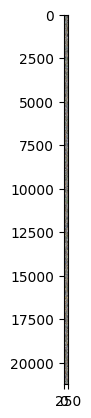

In [ ]:
# Examples of dataset 데이터가 잘 만들어졌음을 확인가능.

def imshow(img):
  img = img /2 + 0.5
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(trainloader)
imgs, labels = next(dataiter)

imshow(torchvision.utils.make_grid(imgs))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# **Your own CNN**

You can implement your own network using libraries such as `torch.nn`and `torch.nn.functional`.

`SimpleNet` and `VGG11` are examples to help your understand the implementation of the network.

So, you can modify the given codes or create another awesome neural network for CIFAR-10 classification.

In [ ]:
# Model 교수님이 짜두신 네트워크 2개. 여기서 어떻게 발전시킬건지 조원들이랑 논의, 새로운 네트워크 개발해야.


class BottleneckBlock(nn.Module):
    expansion = 4  # Define the expansion as a class attribute

    def __init__(self, in_channels, out_channels, stride=1):
        super(BottleneckBlock, self).__init__()
        self.stride = stride

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.conv3 = nn.Conv2d(out_channels, out_channels * BottleneckBlock.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * BottleneckBlock.expansion)

        self.relu = nn.ReLU(inplace=True)

        if stride != 1 or in_channels != out_channels * BottleneckBlock.expansion:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BottleneckBlock.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * BottleneckBlock.expansion)
            )
        else:
            self.downsample = None

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

def ResNet50(num_classes=10):
    return ResNet(BottleneckBlock, [3, 4, 6, 3], num_classes)

def ResNet101(num_classes=10):
    return ResNet(BottleneckBlock, [3, 4, 23, 3], num_classes)



# **Loss function and optimizer**

Set the **loss function and optimizer** for training CNN.
You can modify the loss function or optimizer for better performance.

In [ ]:
def modeltype(model, num_classes=10):
    if model == 'resnet50':
        return ResNet50(num_classes)
    elif model == 'resnet101':
        return ResNet101(num_classes)

# Example usage:
learning_rate = 1e-3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = modeltype('resnet50').to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# **Train the network**

Train your own network using the above loss function and optimizer.

In [ ]:
# Train the model 거의 바꿀 필요 없다.

train_accuracy = []
epochs = 100  # number of epochs 몇번을 돌릴지 정해주어야. 5번 돌리면 성능이 거의 안나올것.

for epoch in range(epochs):
    correct = 0
    total = 0
    loss_tmp = 0.0
    epoch_loss = 0.0
    for i, data in enumerate(trainloader, start=0): #trainloader 위에서 지정함.
        # Load the data
        inputs, labels = data #data 불러온다.
        inputs = inputs.to(device) #gpu로 보내준다.
        labels = labels.to(device)

        # Estimate the output using the network
        outputs = model(inputs)

        # Calculate the loss between the output of the network and label
        loss = loss_func(outputs, labels) #loss 함수 계산

        # Optimize the network 네트워크 한번 업데이트
        optimizer.zero_grad()
        loss.backward() #BACKpropagation 개시
        optimizer.step() #running mate 기준으로 셉타 마이너스 입실론곱하기그레디언트 해준 과정이 step으로 가준다.

        loss_tmp += loss.data
        epoch_loss += loss.data #전체 train loss 값, i+1은 전체 epoch 값
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if i % 5000 == 4999:    # Print loss every 5000 mini-batches # 5000번의 미니 배치마다 손실 출력
            print('[Epoch - %d, Iteration - %5d] Loss: %.3f' %
                  (epoch + 1, i + 1, loss_tmp / (i+1))) #결과값 visualization 해주는 거라 바꿀 필요 없다.
            loss_tmp = 0.0

    # Update the learning rate according to the learnig rate scheduler
    scheduler.step() #running mate 한번 업데이트

     # 에포크가 끝날 때마다 정확도를 train_accuracy 리스트에 추가
    epoch_accuracy = 100 * correct / total
    train_accuracy.append(epoch_accuracy)

    print(f'Epoch [{epoch+1}], Loss: {epoch_loss/(i+1):.4f}, Accuracy: {epoch_accuracy:.2f}%')

print('Finished Training')

[Epoch - 1] Loss: 2.566
Finished Training


## **Test the network**

Test the trained network using the testset.

Accuracy of the network on the 10,000 test images is the final accuracy of your network.

The closer the accuray is to 100%, the better the network classifies the input image.

GroundTruth:    cat  ship  ship plane
Predicted:   frog truck truck  ship


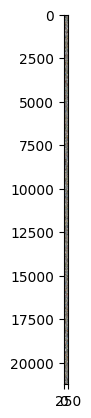

In [ ]:
# Test the trained model with sample 고치면 안된다.

dataiter_test = iter(testloader)
img_test, labels_test = next(dataiter_test)

imshow(torchvision.utils.make_grid(img_test))
print('GroundTruth: ', ' '.join('%5s' % classes[labels_test[j]] for j in range(4)))

img_test = img_test.to(device)
labels_test = labels_test.to(device)

# Prediction
outputs_test = model(img_test)
_, predicted = torch.max(outputs_test.data, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

In [ ]:
# Test the trained model with overall test dataset
criterion = nn.CrossEntropyLoss()

model.eval()
correct = 0
total = 0
test_loss = 0.0

for data in testloader:
    # Load the data
    inputs_test, labels_test = data
    inputs_test = inputs_test.to(device)
    labels_test = labels_test.to(device)

    # Estimate the output using the trained network
    outputs_test = model(inputs_test)
    loss = criterion(outputs_test, labels_test)
    test_loss += loss.item()

    _, predicted = torch.max(outputs_test.data, 1)

    # Calculate the accuracy
    total += labels_test.size(0)
    correct += (predicted == labels_test).sum().item()

test_loss /= len(testloader)
test_accuracy = 100 * correct / total

# Final accuracy
print('Accuracy of the network on the 10,000 test images: %d %%' % test_accuracy)

#import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Test the trained model with overall test dataset
criterion = nn.CrossEntropyLoss()

model.eval()
correct = 0
total = 0
test_loss = 0.0

for data in testloader:
    # Load the data
    inputs_test, labels_test = data
    inputs_test = inputs_test.to(device)
    labels_test = labels_test.to(device)

    # Estimate the output using the trained network
    outputs_test = model(inputs_test)
    loss = criterion(outputs_test, labels_test)
    test_loss += loss.item()

    _, predicted = torch.max(outputs_test.data, 1)

    # Calculate the accuracy
    total += labels_test.size(0)
    correct += (predicted == labels_test).sum().item()

test_loss /= len(testloader)
test_accuracy = 100 * correct / total

# Final accuracy
print('Accuracy of the network on the 10,000 test images: %d %%' % test_accuracy)

# Assuming train_accuracy and epoch_loss are lists of floats or 0-d tensors
train_accuracy = [torch.tensor(0.8), torch.tensor(0.85), torch.tensor(0.9)]  # 예시 데이터
epoch_loss = [torch.tensor(0.5), torch.tensor(0.4), torch.tensor(0.3)]  # 예시 데이터
epochs = len(train_accuracy)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(range(epochs), [acc.item() if torch.is_tensor(acc) else acc for acc in train_accuracy], label='Train Accuracy')
plt.plot(range(epochs), [test_accuracy] * epochs, label='Test Accuracy')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(epochs), [loss.item() if torch.is_tensor(loss) else loss for loss in epoch_loss], label='Train Loss')
plt.plot(range(epochs), [test_loss] * epochs, label='Test Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


OutOfMemoryError: CUDA out of memory. Tried to allocate 60.00 MiB. GPU 